# Packages

In [ ]:
!pip install joypy

import requests
import time
import random
import json
import pandas as pd
import re
from bs4 import BeautifulSoup
import lxml.html as lx
from tqdm import tqdm
import pyperclip
import seaborn as sns
import matplotlib.pyplot as plt
from joypy import joyplot
import branca.colormap as cm

from google.colab import drive
drive.mount('/content/drive')

from google.colab import files
from IPython.display import Image

from geopy.distance import geodesic

import nltk
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords

from wordcloud import WordCloud
from transformers import pipeline

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

import folium
from IPython.display import display

import io
import base64

import plotly.express as px

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


# Region

In [ ]:
coordinates = [
    [38.5491, -121.744],  # Davis
    [38.6807, -121.7553],  # Woodland
    [38.5741, -121.5831],  # West Sac
    [38.4508, -121.8287]  # Dixon
    ]

map_center = [38.5491, -121.744]

radius_miles = [4.6, 3.5, 3.7, 2.5]

m = folium.Map(location=map_center, zoom_start=11)

for i,coord in enumerate(coordinates):
    folium.Circle(
        location=coord,
        radius=radius_miles[i] * 1509.34,
        color='gold',

        fill=False,
        fill_color='blue',
        fill_opacity=0.1
    ).add_to(m)

m.save(f"/content/drive/Shareddrives/STA 220 Project/region_map.html")
m

# Craigslist

In [ ]:
def get_craigslist_html_list(url):
  r = requests.get(url)
  html = lx.fromstring(r.text)
  html_list = html.xpath('//a[contains(@href, "http")]//@href')
  return html_list

In [ ]:
url_list = [
    "https://sacramento.craigslist.org/search/davis-ca/apa?lat=38.5491&lon=-121.7444&search_distance=4.6#search=2~gallery~0",
    "https://sacramento.craigslist.org/search/woodland-ca/apa?lat=38.6807&lon=-121.7553&search_distance=3.5#search=2~gallery~0",
    "https://sacramento.craigslist.org/search/west-sacramento-ca/apa?lat=38.5741&lon=-121.5831&search_distance=3.7#search=2~gallery~0",
    "https://sacramento.craigslist.org/search/west-sacramento-ca/apa?lat=38.4508&lon=-121.8287&search_distance=2.5#search=2~gallery~0"
]

davis_apt_html_list = get_craigslist_html_list(url_list[0])
wood_apt_html_list = get_craigslist_html_list(url_list[1])
westsac_apt_html_list = get_craigslist_html_list(url_list[2])
dixon_apt_html_list = get_craigslist_html_list(url_list[3])

In [ ]:
def get_craigslist_rental(html_list):
  agents_list = [
      "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
      "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
      "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36",
      "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:114.0) Gecko/20100101 Firefox/114.0",
      "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Version/17.0 Safari/537.36",
      "Mozilla/5.0 (iPhone; CPU iPhone OS 17_0 like Mac OS X) AppleWebKit/537.36 (KHTML, like Gecko) Version/17.0 Mobile/15E148 Safari/537.36",
  ]

  rental_list = []
  for apt_html in tqdm(html_list,desc = 'Processing html'):
    try:
      random_user_agent = random.choice(agents_list)
      headers = {"User-Agent": random_user_agent}
      r = requests.get(apt_html,headers = headers)
      time.sleep(random.randint(5,10))
      html = lx.fromstring(r.text)
      address = html.xpath("//h2[@class='street-address']/text()")
      price = html.xpath("//span[@class='price']/text()")
      price = re.sub(r"[^\d]", "", price[0])
      price = int(price)
      rooms = html.xpath("//span[@class='attr important']/text()")[0]
      rooms = re.sub(r'\s*/\s*', '/', rooms.strip())
      area = html.xpath("//span[@class='attr important']/text()")[1]
      area = area.strip()
      period = html.xpath("//span[@class='valu']/a/text()")[0]
      rental_list.append({
          'url': apt_html,
          'address': address,
          'price': price,
          'rooms': rooms,
          'area': area,
          'period': period,
      })
    except:
      continue
  return pd.DataFrame(rental_list)

In [ ]:
davis_result_list = get_craigslist_rental(davis_apt_html_list)
wood_result_list = get_craigslist_rental(wood_apt_html_list)
westsac_result_list = get_craigslist_rental(westsac_apt_html_list)
dixon_result_list = get_craigslist_rental(dixon_apt_html_list)

Processing html: 100%|██████████| 19/19 [02:29<00:00,  7.86s/it]


In [ ]:
def clean_craigslist_data(df):
  df['address'] = df['address'].map(lambda x: str(x)[2:-2])
  df = df.drop_duplicates(subset = ['address','price','rooms','area'])
  df = df[df['address'] != '']
  df = df[~df['rooms'].str.contains('0BR')].iloc[:,1:]
  df['price'] = df['price'].astype(int)
  df = df.groupby(['address','rooms']).agg({'price': 'first', 'area': 'first'}).reset_index()
  return df

In [ ]:
davis_result_df_clean = clean_craigslist_data(davis_result_list)
wood_result_df_clean = clean_craigslist_data(wood_result_list)
westsac_result_df_clean = clean_craigslist_data(westsac_result_list)
dixon_result_df_clean = clean_craigslist_data(dixon_result_list)

from google.colab import files
davis_result_df_clean.to_excel('/content/drive/Shareddrives/STA 220 Project/davis_rental_craiglist.xlsx', index=False)
wood_result_df_clean.to_excel('/content/drive/Shareddrives/STA 220 Project/wood_rental_craiglist.xlsx', index=False)
westsac_result_df_clean.to_excel('/content/drive/Shareddrives/STA 220 Project/westsac_rental_craiglist.xlsx', index=False)
dixon_result_df_clean.to_excel('/content/drive/Shareddrives/STA 220 Project/dixon_rental_craiglist.xlsx', index=False)

In [ ]:
davis_result_df_clean = pd.read_excel('/content/drive/Shareddrives/STA 220 Project/davis_rental_craiglist.xlsx')
wood_result_df_clean = pd.read_excel('/content/drive/Shareddrives/STA 220 Project/wood_rental_craiglist.xlsx')
westsac_result_df_clean = pd.read_excel('/content/drive/Shareddrives/STA 220 Project/westsac_rental_craiglist.xlsx')
dixon_result_df_clean = pd.read_excel('/content/drive/Shareddrives/STA 220 Project/dixon_rental_craiglist.xlsx')

# Zillow

In [ ]:
url = 'https://www.zillow.com/async-create-search-page-state'

payload = {
    "searchQueryState": {
        "pagination": {},
        "isMapVisible": True,
        "mapBounds": {
            "west": -121.84802528815679,
            "east": -121.64855476813726,
            "south": 38.507934165772205,
            "north": 38.61330504134711
        },
        "mapZoom": 13,
        "usersSearchTerm": "Davis CA",
        "regionSelection": [
            {"regionId": 51659, "regionType": 6}
        ],
        "filterState": {
            "isForRent": {"value": True},
            "isForSaleByAgent": {"value": False},
            "isForSaleByOwner": {"value": False},
            "isNewConstruction": {"value": False},
            "isComingSoon": {"value": False},
            "isAuction": {"value": False},
            "isForSaleForeclosure": {"value": False},
            "isSingleFamily": {"value": False},
            "isTownhouse": {"value": False},
            "isMultiFamily": {"value": False},
            "isLotLand": {"value": False},
            "isManufactured": {"value": False}
        },
        "isListVisible": True
    },
    "wants": {"cat1": ["mapResults"]},
    "requestId": 2,
    "isDebugRequest": False
}

headers = {
    "accept": "*/*",
    "accept-encoding": "gzip, deflate, br, zstd",
    "accept-language": "en-US,en;q=0.9,zh-CN;q=0.8,zh;q=0.7,en-GB;q=0.6",
    "content-type": "application/json",
    "cookie": "zgcus_aeut=AEUUT_7989edff-f7f3-11ee-84e8-2a76bf51e45e; zgcus_aeuut=AEUUT_7989edff-f7f3-11ee-84e8-2a76bf51e45e; _hp2_id.1215457233=%7B%22userId%22%3A%226415933418001300%22%2C%22pageviewId%22%3A%22404787467916344%22%2C%22sessionId%22%3A%225798795807420139%22%2C%22identity%22%3Anull%2C%22trackerVersion%22%3A%224.0%22%7D; zguid=24|%248a4ee366-95ba-4e3b-a90a-31160d59742a; zjs_anonymous_id=%228a4ee366-95ba-4e3b-a90a-31160d59742a%22; zjs_user_id=null; zg_anonymous_id=%22368ca253-899c-41c8-87c9-61abc4c70e59%22; _ga=GA1.2.514698053.1740014631; _pxvid=5686396d-ef29-11ef-8615-aba66b3c0e70; _gcl_au=1.1.2057070524.1740014633; _scid=4Ys2HHiG0OBgYRq6kcnEVymQ8pmluGQA; _tt_enable_cookie=1; _ttp=SdCxdGcWo8TB9enUKetKo5HgIsB.tt.1; _pin_unauth=dWlkPU9Ua3dPV1V3WkRZdE1HUTVOeTAwTjJJekxXRTNPVGt0TkdNM09HSXpOREpoTmpOaA; FSsampler=666122190; optimizelyEndUserId=oeu1740029104663r0.474687802073408; __spdt=770eb123c5e84d5185c1935fb098a548; optimizelySession=1740029109080; zgsession=1|34e8521d-38cb-4ffe-ae8f-8c4f8d5c7dc3; _gid=GA1.2.1605533137.1741586706; JSESSIONID=F8A7E766A7A70374A1A20FE8D97E7CC9; pxcts=9d4c6e9b-fd75-11ef-adfc-63a3145f42cd; _rdt_uuid=1740014633375.fb736d8a-87ba-49d6-a90e-43d0283997fb; _scid_r=8As2HHiG0OBgYRq6kcnEVymQ8pmluGQAXLHRnA; _ScCbts=%5B%5D; DoubleClickSession=true; _clck=1qjb5g1%7C2%7Cfu3%7C0%7C1877; _sctr=1%7C1741507200000; _dd_s=rum=0&expire=1741587613460; web-platform-data=%7B%22wp-dd-rum-session%22%3A%7B%22doNotTrack%22%3Atrue%7D%7D; _uetsid=9e87b010fd7511ef8d0e0f93d6b808ef; _uetvid=58e18fc0ef2911ef988a2b1dbeb4401c; _px3=bb6f33d47cb25f47e44b22b8cd75b39c686caf836cf52513a60c5b8c7fa0115d:a7tx+qEfUjBvvOuY/zhGggYMRGZEmrqDjo+QVjd6v+1lMHLKK2HKE5FZnORlsB9SDBRGrnIqSHCKR3Ssunh9hA==:1000:DOS7AaANiy5+LFdId4jbrpeYJp0t3yGc4NYefJpy30702c6U0hLSt8i+NVD2Nwbz5re0kPnEkHLRdLIVJmvmcX0N47T3dj9d6sRWdXKcUsnfU/OSRacNwu4JgG1YoFpMv7NKffCEws22QXQJPlff3JTYU9CZcaMj6xyYS74Px/tJxpClcrZagCKGnBolVGCnnmlc1drp39JpAhq5biTOSabJ8XkcJ04YjQkIITB0fKY=",
    "origin": "https://www.zillow.com",
    "priority": "u=1, i",
    "referer": "https://www.zillow.com/davis-ca/rentals/?searchQueryState=%7B%22pagination%22%3A%7B%7D%2C%22isMapVisible%22%3Atrue%2C%22mapBounds%22%3A%7B%22west%22%3A-121.76243867363621%2C%22east%22%3A-121.70656289543797%2C%22south%22%3A38.531251630742496%2C%22north%22%3A38.58393929785879%7D%2C%22regionSelection%22%3A%5B%7B%22regionId%22%3A51659%2C%22regionType%22%3A6%7D%5D%2C%22filterState%22%3A%7B%22fr%22%3A%7B%22value%22%3Atrue%7D%2C%22fsba%22%3A%7B%22value%22%3Afalse%7D%2C%22fsbo%22%3A%7B%22value%22%3Afalse%7D%2C%22nc%22%3A%7B%22value%22%3Afalse%7D%2C%22cmsn%22%3A%7B%22value%22%3Afalse%7D%2C%22auc%22%3A%7B%22value%22%3Afalse%7D%2C%22fore%22%3A%7B%22value%22%3Afalse%7D%2C%22mf%22%3A%7B%22value%22%3Afalse%7D%2C%22land%22%3A%7B%22value%22%3Afalse%7D%2C%22manu%22%3A%7B%22value%22%3Afalse%7D%2C%22tow%22%3A%7B%22value%22%3Afalse%7D%2C%22sf%22%3A%7B%22value%22%3Afalse%7D%7D%2C%22isListVisible%22%3Atrue%2C%22mapZoom%22%3A14%2C%22usersSearchTerm%22%3A%22Davis%20CA%22%7D",
    "sec-ch-ua": "\"Chromium\";v=\"134\", \"Not:A-Brand\";v=\"24\", \"Microsoft Edge\";v=\"134\"",
    "sec-ch-ua-mobile": "?0",
    "sec-ch-ua-platform": "\"Windows\"",
    "sec-fetch-dest": "empty",
    "sec-fetch-mode": "cors",
    "sec-fetch-site": "same-origin",
    "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/134.0.0.0 Safari/537.36 Edg/134.0.0.0"
}

r_davis = requests.put(url, json=payload, headers=headers)


In [ ]:
url = 'https://www.zillow.com/async-create-search-page-state'

payload = {
    "searchQueryState": {
        "pagination": {},
        "isMapVisible": False,
        "mapBounds": {
            "west": -122.18263011914063,
            "east": -121.45478588085938,
            "south": 38.443459135499964,
            "north": 39.01126819440303
        },
        "mapZoom": 14,
        "usersSearchTerm": "Woodland, CA",
        "regionSelection": [
            {"regionId": 48569, "regionType": 6}
        ],
        "filterState": {
            "isForRent": {"value": True},
            "isForSaleByAgent": {"value": False},
            "isForSaleByOwner": {"value": False},
            "isNewConstruction": {"value": False},
            "isComingSoon": {"value": False},
            "isAuction": {"value": False},
            "isForSaleForeclosure": {"value": False},
            "isSingleFamily": {"value": False},
            "isTownhouse": {"value": False},
            "isMultiFamily": {"value": False},
            "isLotLand": {"value": False},
            "isManufactured": {"value": False}
        },
        "isListVisible": True
    },
    "wants": {"cat1": ["mapResults"]},
    "requestId": 6,
    "isDebugRequest": False
}

r_wood = requests.put(url, json=payload, headers=headers)


In [ ]:
url = 'https://www.zillow.com/async-create-search-page-state'

payload = {
    "searchQueryState": {
        "pagination": {},
        "isMapVisible": False,
        "mapBounds": {
            "west": -121.96957870507813,
            "east": -121.60565658593751,
            "south": 38.26693556905172,
            "north": 38.55210073246159
        },
        "mapZoom": 11,
        "usersSearchTerm": "Dixon, CA",
        "regionSelection": [
            {"regionId": 17788, "regionType": 6}
        ],
        "filterState": {
            "isForRent": {"value": True},
            "isForSaleByAgent": {"value": False},
            "isForSaleByOwner": {"value": False},
            "isNewConstruction": {"value": False},
            "isComingSoon": {"value": False},
            "isAuction": {"value": False},
            "isForSaleForeclosure": {"value": False},
            "isSingleFamily": {"value": False},
            "isTownhouse": {"value": False},
            "isMultiFamily": {"value": False},
            "isLotLand": {"value": False},
            "isManufactured": {"value": False}
        },
        "isListVisible": True
    },
    "wants": {"cat1": ["mapResults"]},
    "requestId": 16,
    "isDebugRequest": False
}


r_dixon = requests.put(url, json=payload, headers=headers)


In [ ]:
url = 'https://www.zillow.com/async-create-search-page-state'

payload = {
    "searchQueryState": {
        "pagination": {},
        "isMapVisible": False,
        "mapBounds": {
            "west": -121.96210761914062,
            "east": -121.23426338085937,
            "south": 38.348883239449044,
            "north": 38.91744018703359
        },
        "mapZoom": 11,
        "usersSearchTerm": "West Sacramento, CA",
        "regionSelection": [
            {"regionId": 41665, "regionType": 6}
        ],
        "filterState": {
            "isForRent": {"value": True},
            "isForSaleByAgent": {"value": False},
            "isForSaleByOwner": {"value": False},
            "isNewConstruction": {"value": False},
            "isComingSoon": {"value": False},
            "isAuction": {"value": False},
            "isForSaleForeclosure": {"value": False},
            "isSingleFamily": {"value": False},
            "isTownhouse": {"value": False},
            "isMultiFamily": {"value": False},
            "isLotLand": {"value": False},
            "isManufactured": {"value": False}
        },
        "isListVisible": True
    },
    "wants": {"cat1": ["mapResults"]},
    "requestId": 25,
    "isDebugRequest": False
}


r_west = requests.put(url, json=payload, headers=headers)


In [ ]:
def clean_price(price):
  if isinstance(price, (int, float)):
    return int(price)
  elif isinstance(price, str):
    match = re.search(r'\d+', price.replace(',', ''))
    return int(match.group()) if match else "N/A"
  return "N/A"

def process_rental_listings(response):
  rental_list = response.json()["cat1"]["searchResults"]["mapResults"]

  cleaned_data = []
  for rental in rental_list:
    home_info = rental.get("hdpData", {}).get("homeInfo", {})
    lat_long = rental.get("latLong", {})

    if home_info:
      price = clean_price(home_info.get("price", "N/A"))
      data = {
          "Apartment name": rental.get("statusText", "N/A"),
          "Price": price,
          "Street Address": home_info.get("streetAddress", "N/A"),
          "Bedrooms": home_info.get("bedrooms", 0),
          "Bathrooms": home_info.get("bathrooms", 0),
          "Living Area (sqft)": home_info.get("livingArea", "N/A"),
          "Latitude": lat_long.get("latitude", "N/A"),
          "Longitude": lat_long.get("longitude", "N/A"),
      }
    else:
      price = clean_price(rental.get("price", "N/A"))
      data = {
          "Apartment name": rental.get("statusText", "N/A"),
          "Price": price,
          "Street Address": rental.get("address", "N/A"),
          "Bedrooms": rental.get("minBeds", 0),
          "Bathrooms": rental.get("minBaths", 0),
          "Living Area (sqft)": rental.get("minArea", "N/A"),
          "Latitude": lat_long.get("latitude", "N/A"),
          "Longitude": lat_long.get("longitude", "N/A"),
      }
    cleaned_data.append(data)

  df = pd.DataFrame(cleaned_data)
  df["Bedrooms"] = df["Bedrooms"].fillna(0).astype(int)
  df["Bathrooms"] = df["Bathrooms"].fillna(0).astype(int)

  df["Unit Price"] = df.apply(lambda row: row["Price"] if row["Bedrooms"] == 0 else row["Price"] / row["Bedrooms"], axis=1)

  return df

In [ ]:
davis_rental_df = process_rental_listings(r_davis)
wood_rental_df = process_rental_listings(r_wood)
west_rental_df = process_rental_listings(r_west)
dixon_rental_df = process_rental_listings(r_dixon)

In [ ]:
davis_rental_df = davis_rental_df[(davis_rental_df["Unit Price"] >= 600)]
wood_rental_df = wood_rental_df[(wood_rental_df["Unit Price"] >= 600)]
west_rental_df = west_rental_df[(west_rental_df["Unit Price"] >= 600)]
dixon_rental_df = dixon_rental_df[(dixon_rental_df["Unit Price"] >= 600)]

In [ ]:
davis_rental_df.to_excel('/content/drive/Shareddrives/STA 220 Project/davis_rental_zillow.xlsx', index=False)
wood_rental_df.to_excel('/content/drive/Shareddrives/STA 220 Project/wood_rental_zillow.xlsx', index=False)
west_rental_df.to_excel('/content/drive/Shareddrives/STA 220 Project/westsac_rental_zillow.xlsx', index=False)
dixon_rental_df.to_excel('/content/drive/Shareddrives/STA 220 Project/dixon_rental_zillow.xlsx', index=False)

In [ ]:
davis_rental_df = pd.read_excel('/content/drive/Shareddrives/STA 220 Project/davis_rental_zillow.xlsx')
wood_rental_df = pd.read_excel('/content/drive/Shareddrives/STA 220 Project/wood_rental_zillow.xlsx')
west_rental_df = pd.read_excel('/content/drive/Shareddrives/STA 220 Project/westsac_rental_zillow.xlsx')
dixon_rental_df = pd.read_excel('/content/drive/Shareddrives/STA 220 Project/dixon_rental_zillow.xlsx')

In [ ]:
summary_stats = {
    "Davis": round(davis_rental_df["Unit Price"].describe(),0),
    "Woodland": round(wood_rental_df["Unit Price"].describe()),
    "West Sacramento": round(west_rental_df["Unit Price"].describe()),
    "Dixon": round(dixon_rental_df["Unit Price"].describe()),
}
print(summary_stats)


{'Davis': count     107.0
mean     1471.0
std       499.0
min       633.0
25%      1050.0
50%      1350.0
75%      1884.0
max      3139.0
Name: Unit Price, dtype: float64, 'Woodland': count      22.0
mean     1475.0
std       300.0
min       733.0
25%      1461.0
50%      1538.0
75%      1638.0
max      1999.0
Name: Unit Price, dtype: float64, 'West Sacramento': count      35.0
mean     1415.0
std       367.0
min       698.0
25%      1250.0
50%      1395.0
75%      1718.0
max      2175.0
Name: Unit Price, dtype: float64, 'Dixon': count       5.0
mean     1190.0
std       329.0
min       925.0
25%      1000.0
50%      1077.0
75%      1200.0
max      1750.0
Name: Unit Price, dtype: float64}


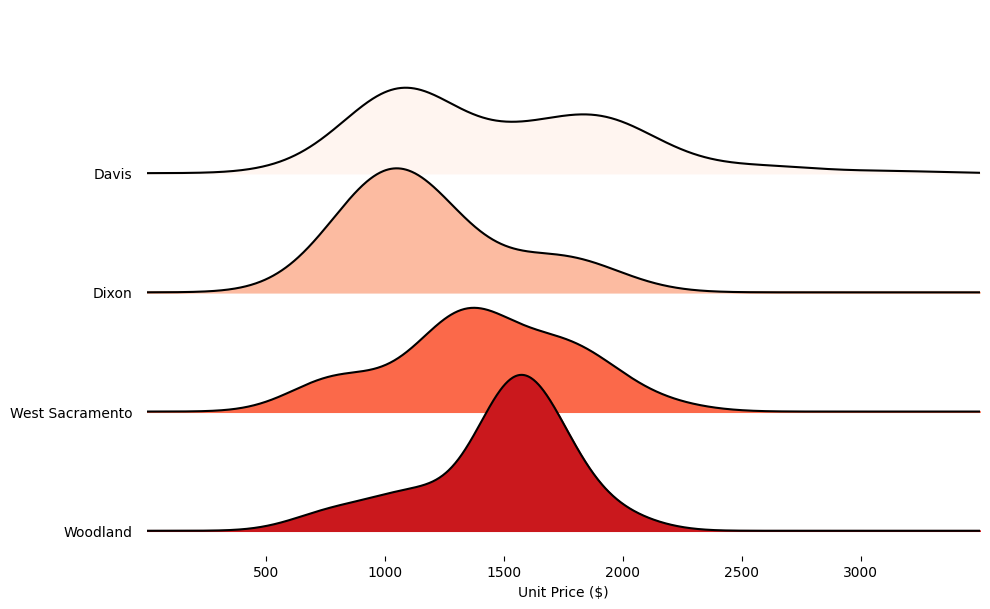

In [ ]:
davis_rental_df["Region"] = "Davis"
wood_rental_df["Region"] = "Woodland"
west_rental_df["Region"] = "West Sacramento"
dixon_rental_df["Region"] = "Dixon"

combined_df = pd.concat([davis_rental_df, wood_rental_df, west_rental_df, dixon_rental_df])

fig, axes = joyplot(
    data=combined_df,
    by="Region",
    column="Unit Price",
    figsize=(10, 6),
    colormap=sns.color_palette("Reds", as_cmap=True),
    x_range=[0, 3500],
)

plt.xlabel("Unit Price ($)")

plt.savefig("/content/drive/Shareddrives/STA 220 Project/ridgeline.png", bbox_inches='tight')
plt.show()

In [ ]:
def plot_rental_map(df, map_center, name):
    rental_map = folium.Map(location=map_center, zoom_start=13.8)

    min_price, max_price = df["Unit Price"].min(), df["Unit Price"].max()
    colormap = cm.linear.Reds_09.scale(min_price, max_price)

    for _, row in df.iterrows():
        price = row["Unit Price"]
        color = colormap(price)

        folium.CircleMarker(
            location=[row["Latitude"], row["Longitude"]],
            radius=10,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=f'${price:.2f}/bedroom',
        ).add_to(rental_map)

    colormap.caption = "Unit Price ($/bedroom)"
    rental_map.add_child(colormap)

    rental_map.save(f"/content/drive/Shareddrives/STA 220 Project/{name}_rental_map.html")
    display(rental_map)

In [ ]:
plot_rental_map(davis_rental_df, [38.5449, -121.7405], 'davis')

In [ ]:
plot_rental_map(wood_rental_df, [38.6785, -121.7733],'wood')

In [ ]:
plot_rental_map(dixon_rental_df, [38.4458, -121.8233],'dixon')

In [ ]:
plot_rental_map(west_rental_df, [38.5805, -121.5302],'westsac')

# apts

In [ ]:
def apts(region):
    apartments = []
    url = f'https://www.apartments.com/apartments/{region}-ca/'
    headers = {
      "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/134.0.0.0 Safari/537.36 Edg/134.0.0.0",
      "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7",
      "Accept-Encoding": "gzip, deflate, br, zstd",
      "Accept-Language": "en-US,en;q=0.9,zh-CN;q=0.8,zh;q=0.7,en-GB;q=0.6",
      "Cache-Control": "no-cache",
      "Pragma": "no-cache",
      "Referer": "https://www.apartments.com/",
      "Sec-Ch-Ua": '"Chromium";v="134", "Not:A-Brand";v="24", "Microsoft Edge";v="134"',
      "Sec-Ch-Ua-Mobile": "?0",
      "Sec-Ch-Ua-Platform": '"Windows"',
      "Sec-Fetch-Dest": "document",
      "Sec-Fetch-Mode": "navigate",
      "Sec-Fetch-Site": "cross-site",
      "Sec-Fetch-User": "?1",
      "Upgrade-Insecure-Requests": "1"
      }

    r = requests.get(url, headers=headers)
    soup = BeautifulSoup(r.text, "html.parser")

    listings = soup.find_all("article", class_="placard")


    for listing in tqdm(listings, desc = 'Processing Listing'):
        name = listing.find("span", class_="js-placardTitle title")
        if not name:
            continue
        name = name.text.strip()

        address = listing.find("div", class_="property-address js-url")
        address = address.text.strip() if address else "N/A"

        price = listing.find("p", class_="property-pricing")
        if not price:
            continue
        price = price.text.strip()

        bedrooms = listing.find("p", class_="property-beds")
        bedrooms = bedrooms.text.strip() if bedrooms else "N/A"

        apartments.append({
            "Region": region,
            "Name": name,
            "Address": address,
            "Price": price,
            "Bedrooms": bedrooms
        })
    time.sleep(0.5)
    for i in range(2,4):
      try:
        url = f'https://www.apartments.com/apartments/{region}-ca/{i}'

        r = requests.get(url, headers=headers)
        time.sleep(0.5)

        soup = BeautifulSoup(r.text, "html.parser")

        listings = soup.find_all("article", class_="placard")


        for listing in tqdm(listings, desc = 'Processing Listing'):
            name = listing.find("span", class_="js-placardTitle title")
            if not name:
                continue
            name = name.text.strip()

            address = listing.find("div", class_="property-address js-url")
            address = address.text.strip() if address else "N/A"

            price = listing.find("p", class_="property-pricing")
            if not price:
                continue
            price = price.text.strip()

            bedrooms = listing.find("p", class_="property-beds")
            bedrooms = bedrooms.text.strip() if bedrooms else "N/A"

            apartments.append({
                "Region": region,
                "Name": name,
                "Address": address,
                "Price": price,
                "Bedrooms": bedrooms
            })
      except:
        continue


    df = pd.DataFrame(apartments)
    return df

In [ ]:
davis_apts_df = apts("davis")
wood_apts_df = apts("woodland")
west_apts_df = apts("west-sacramento")
dixon_apts_df = apts("dixon")

Processing Listing: 100%|██████████| 25/25 [00:00<00:00, 3965.72it/s]


In [ ]:
def clean_apts(df):
  region = df['Region'][0].title()
  df = df[df['Address'].str.contains(region)]
  return df

In [ ]:
davis_apts_df = clean_apts(davis_apts_df)
wood_apts_df = clean_apts(wood_apts_df)
west_apts_df = clean_apts(west_apts_df)
dixon_apts_df = clean_apts(dixon_apts_df)

In [ ]:
davis_apts_df.to_excel('/content/drive/Shareddrives/STA 220 Project/davis_rental_apts.xlsx', index=False)
wood_apts_df.to_excel('/content/drive/Shareddrives/STA 220 Project/wood_rental_apts.xlsx', index=False)
west_apts_df.to_excel('/content/drive/Shareddrives/STA 220 Project/westsac_rental_apts.xlsx', index=False)
dixon_apts_df.to_excel('/content/drive/Shareddrives/STA 220 Project/dixon_rental_apts.xlsx', index=False)

# neighborhoodscout

In [ ]:
def get_crime_data(region):
    url = f"https://www.neighborhoodscout.com/ca/{region}/crime"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/133.0.0.0 Safari/537.36"
    }
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")

    crimerate = soup.find("h1", class_="score")
    crimerate = crimerate.text.strip() if crimerate else "N/A"

    victimchance = soup.find("div", class_="supersmallH3")
    victimchance = " ".join(victimchance.text.split()) if victimchance else "N/A"

    return {"Region": region, "CrimeRate": crimerate, "ChanceVictim": victimchance}

regions = ["woodland", "davis", "west-sacramento", "dixon","san-francisco","berkeley"]

crime_data = [get_crime_data(region) for region in regions]

crime_data = pd.DataFrame(crime_data)

print(crime_data)

            Region CrimeRate ChanceVictim
0         woodland        14     1 in 255
1            davis         4     1 in 427
2  west-sacramento        31     1 in 465
3            dixon        24     1 in 386
4    san-francisco         1     1 in 142
5         berkeley         1     1 in 134


crime rate:100 is safest

Safer than 1% of U.S. cities.

# bestplaces

Cost of living score
       Higher than 100 is more expensive than the national average.
       Lower than 100 is less expensive.

In [ ]:
def get_living_data(region):
    url = f"https://www.bestplaces.net/cost_of_living/city/california/{region}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/133.0.0.0 Safari/537.36"
    }
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")

    grocery_table = soup.find("table", class_="table table-striped")
    grocery = grocery_table.find_all("tr")[2].find_all("td")[1].text.strip()
    utility = grocery_table.find_all("tr")[6].find_all("td")[1].text.strip()
    return {"Region": region, "Grocery": grocery,"Utility": utility}

regions = ["woodland", "davis", "west_sacramento", "dixon","san_francisco"]

grocery_data = [get_living_data(region) for region in regions]

grocery_data = pd.DataFrame(grocery_data)

print(grocery_data)

            Region Grocery Utility
0         woodland   105.6   106.6
1            davis   110.9   108.6
2  west_sacramento   105.3   101.4
3            dixon   108.1   108.6
4    san_francisco   116.6    97.5


# Google reviews

In [ ]:
davis_rental_df = pd.read_excel('/content/drive/Shareddrives/STA 220 Project/davis_rental_zillow.xlsx')
wood_rental_df = pd.read_excel('/content/drive/Shareddrives/STA 220 Project/wood_rental_zillow.xlsx')
west_rental_df = pd.read_excel('/content/drive/Shareddrives/STA 220 Project/westsac_rental_zillow.xlsx')
dixon_rental_df = pd.read_excel('/content/drive/Shareddrives/STA 220 Project/dixon_rental_zillow.xlsx')

In [ ]:
def search_nearest_apartments_within(lat,lng):

  radius_meters = 0.1 * 1609.34 # Within 0.1miles

  url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

  params = {
      "location": f"{lat},{lng}",
      "rankby": "distance",
      'keyword' : 'apartment',
      'key' : '*****************', # Google map API key
    }

  r = requests.get(url, params=params)

  time.sleep(random.uniform(0.1, 0.5))

  result = r.json()['results'][0]
  result_loc = result["geometry"]["location"]
  distance = geodesic((lat, lng), (result_loc["lat"], result_loc["lng"])).meters
  if distance <= radius_meters:
    return result['place_id']
  return None

def search_apartments_name(name,lat,lng):
  url = "https://maps.googleapis.com/maps/api/place/textsearch/json"
  params = {
    "query": name,
    "location": f"{lat},{lng}",
    "radius": 500,
    'key' : '*****************', # Google map API key
    }
  r = requests.get(url, params=params)

  if 'route' in r.json()['results'][0]['types']:
    return None
  else:
    return r.json()['results'][0]['place_id']

def get_google_review(df):
  reviews_list = []

  for i,row in tqdm(df.iterrows(), desc = 'Processing Rentals'):
    if (row['Apartment name'] == 'Apartment for rent') or (row['Apartment name'] == 'For rent') or (row['Apartment name'] == 'For Rent'):
      place_id = search_nearest_apartments_within(row['Latitude'],row['Longitude'])
    else:
      place_id = search_apartments_name(row['Apartment name'],row['Latitude'],row['Longitude'])

    if place_id is None:
      continue
    else:
      url = 'https://maps.googleapis.com/maps/api/place/details/json'
      params = {
        'key' : '*****************', # Google map API key
        'place_id' : place_id,
        'fields' : 'name,rating,geometry,reviews'
      }

      r = requests.get(url,params)
      time.sleep(random.uniform(0.1, 0.5))

      try:
        lat = r.json()['result']['geometry']['location']['lat']
        lng = r.json()['result']['geometry']['location']['lng']
        name = r.json()['result']['name']
        overall_rating = r.json()['result']['rating']

        reviews_list.append({
            'name' : name,
            'overall_rating' : overall_rating,
            'lat' : lat,
            'lng' : lng,
            'old_lat' : row['Latitude'],
            'old_lng' : row['Longitude'],
            'review' : {'rating' : [record['rating'] for record in r.json()['result']['reviews']],
                  'text' : [re.sub(r'\n', ' ', record['text']) for record in r.json()['result']['reviews']]}
              })

      except:
        continue

  return  reviews_list

In [ ]:
davis_reviews_list = get_google_review(davis_rental_df)
wood_reviews_list = get_google_review(wood_rental_df)
westsac_reviews_list = get_google_review(west_rental_df)
dixon_reviews_list = get_google_review(dixon_rental_df)

Processing Rentals: 107it [01:36,  1.11it/s]
Processing Rentals: 22it [00:19,  1.12it/s]
Processing Rentals: 35it [00:28,  1.23it/s]
Processing Rentals: 5it [00:04,  1.15it/s]


In [ ]:
def convert_to_df(reviews_list):
  for entry in reviews_list:
      entry['reviews'] = [{'rating': r, 'text': t} for r, t in zip(entry['review']['rating'], entry['review']['text'])]

  df = pd.json_normalize(
      reviews_list,
      record_path='reviews',
      meta=['name', 'overall_rating', 'lat', 'lng', 'old_lat', 'old_lng']
  ).drop_duplicates(subset=['text'])
  df = df[df['text'] != '']

  return df

In [ ]:
davis_reviews_df = convert_to_df(davis_reviews_list)
wood_reviews_df = convert_to_df(wood_reviews_list)
westsac_reviews_df = convert_to_df(westsac_reviews_list)
dixon_reviews_df = convert_to_df(dixon_reviews_list)

In [ ]:
davis_reviews_df.to_excel('/content/drive/Shareddrives/STA 220 Project/davis_review.xlsx', index=False)
wood_reviews_df.to_excel('/content/drive/Shareddrives/STA 220 Project/wood_review.xlsx', index=False)
westsac_reviews_df.to_excel('/content/drive/Shareddrives/STA 220 Project/westsac_review.xlsx', index=False)
dixon_reviews_df.to_excel('/content/drive/Shareddrives/STA 220 Project/dixon_review.xlsx', index=False)

# Word Cloud

In [ ]:
davis_reviews_df = pd.read_excel('/content/drive/Shareddrives/STA 220 Project/davis_review.xlsx')
wood_reviews_df = pd.read_excel('/content/drive/Shareddrives/STA 220 Project/wood_review.xlsx')
westsac_reviews_df = pd.read_excel('/content/drive/Shareddrives/STA 220 Project/westsac_review.xlsx')
dixon_reviews_df = pd.read_excel('/content/drive/Shareddrives/STA 220 Project/dixon_review.xlsx')

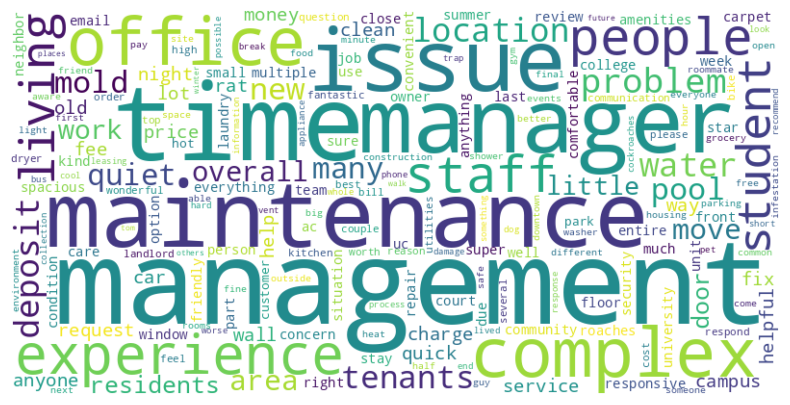

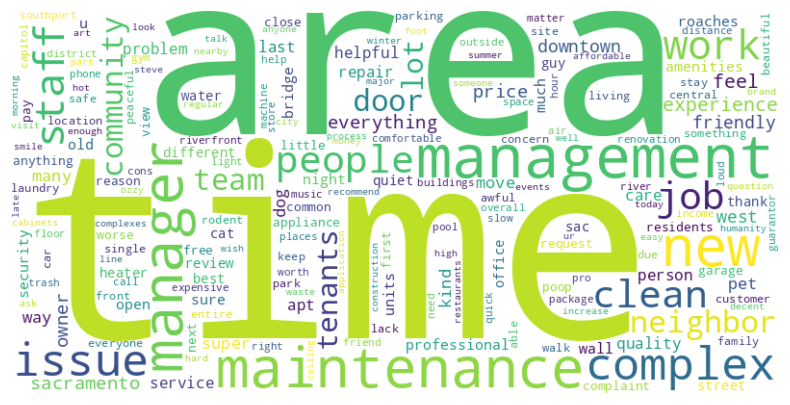

In [ ]:
stop_words = set(stopwords.words('english'))

custom_stopwords = [
    'apartment', 'apartments', 'live', 'month', 'house', 'room', 'place',
    'rental', 'rent', 'lease', 'property', 'tenant', 'residence', 'home',
    'unit', 'building', 'contact',  'sqft',
    'bedroom', 'bathroom', "ve", "n't", "thing", "things", "year", "years", "day",
    "days", "month", "months", "nothing", "resident", "resident","davis"
]

sentiment_stopwords = [
    'good', 'great', 'excellent', 'bad', 'poor', 'nice', 'love', 'hate', 'happy',
    'sad', 'amazing', 'terrible', 'awesome', 'disappointing', 'satisfied', 'unsatisfied'
]
stop_words.update(custom_stopwords)
stop_words.update(sentiment_stopwords)

def clean_text(text):
  text = text.lower()
  tokens = word_tokenize(text)
  tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
  return tokens

def extract_nouns(tokens):
    pos_tags = nltk.pos_tag(tokens)
    nouns = [word for word, tag in pos_tags if (tag.startswith('NN')) or (tag.startswith('JJ'))]
    return nouns

def wordcloud_plt(df,name):
  all_nouns = []
  for comment in df['text']:
    tokens = clean_text(comment)
    nouns = extract_nouns(tokens)
    all_nouns.extend(nouns)
  text_for_wordcloud = " ".join(all_nouns)
  wordcloud = WordCloud(width=800, height=400, background_color="white", collocations=False).generate(text_for_wordcloud)
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.savefig(f'/content/drive/Shareddrives/STA 220 Project/cloud{name}.png')
  plt.show()

wordcloud_plt(davis_reviews_df,'davis')
wordcloud_plt(westsac_reviews_df,'westsac')



# Sentiment Analysis

In [ ]:
sentiment_task = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment-latest")
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

def sentiment_analysis(df):
  sentiment_scores_list = []
  for review in tqdm(df['text'], desc = 'Processing Reviews'):
    try:
      result = sentiment_task(review)[0]
    except:
      summary = summarizer(review, max_length=500, min_length=400, do_sample=False)
      result = sentiment_task(summary[0]['summary_text'])[0]
    sentiment = result['label']
    score = result['score']
    if sentiment == 'positive':
      sentiment_scores_list.append(score)
    elif sentiment == 'negative':
      sentiment_scores_list.append(-score)
    else:
      sentiment_scores_list.append(0)
  return sentiment_scores_list

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
davis_sentiment_scores_list = sentiment_analysis(davis_reviews_df)
wood_sentiment_scores_list = sentiment_analysis(wood_reviews_df)
westsac_sentiment_scores_list = sentiment_analysis(westsac_reviews_df)
dixon_sentiment_scores_list = sentiment_analysis(dixon_reviews_df)


Processing Reviews: 100%|██████████| 9/9 [00:03<00:00,  2.81it/s]


In [ ]:
davis_sentiment_df = davis_reviews_df
wood_sentiment_df = wood_reviews_df
westsac_sentiment_df = westsac_reviews_df
dixon_sentiment_df = dixon_reviews_df

davis_sentiment_df['Sentiment'] = davis_sentiment_scores_list
wood_sentiment_df['Sentiment'] = wood_sentiment_scores_list
westsac_sentiment_df['Sentiment'] = westsac_sentiment_scores_list
dixon_sentiment_df['Sentiment'] = dixon_sentiment_scores_list


In [ ]:
davis_sentiment_df.to_excel('/content/drive/Shareddrives/STA 220 Project/davis_sentiment.xlsx', index=False)
wood_sentiment_df.to_excel('/content/drive/Shareddrives/STA 220 Project/wood_sentiment.xlsx', index=False)
westsac_sentiment_df.to_excel('/content/drive/Shareddrives/STA 220 Project/westsac_sentiment.xlsx', index=False)
dixon_sentiment_df.to_excel('/content/drive/Shareddrives/STA 220 Project/dixon_sentiment.xlsx', index=False)

In [ ]:
davis_sentiment_df = pd.read_excel('/content/drive/Shareddrives/STA 220 Project/davis_sentiment.xlsx')
wood_sentiment_df = pd.read_excel('/content/drive/Shareddrives/STA 220 Project/wood_sentiment.xlsx')
westsac_sentiment_df = pd.read_excel('/content/drive/Shareddrives/STA 220 Project/westsac_sentiment.xlsx')
dixon_sentiment_df = pd.read_excel('/content/drive/Shareddrives/STA 220 Project/dixon_sentiment.xlsx')

In [ ]:
def rating_df(df):
  df_result = df.groupby(['lat', 'lng','name', 'old_lat', 'old_lng']).mean(['rating','overall_rating','Sentiment']).reset_index()
  df_result['Sentiment'] = (5/2) * (df_result['Sentiment'] + 1)
  return df_result


def plot_overall(df, map_center,name):
  df = rating_df(df)

  map = folium.Map(location=map_center, zoom_start=13.8)

  min_score, max_score = df["overall_rating"].min(), df["overall_rating"].max()
  colormap = cm.linear.Reds_09.scale(min_score, max_score)
  colormap.caption = 'Overall Rating'

  for _, row in df.iterrows():
    color = colormap(row["overall_rating"])

    folium.CircleMarker(
        location=[row["lat"], row["lng"]],
        radius=10,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"{row['overall_rating']:.2f}",
        ).add_to(map)


  map.add_child(colormap)

  map.save(f"/content/drive/Shareddrives/STA 220 Project/{name}_overall_map.html")
  display(map)

def plot_relevant(df, map_center,name):
  df = rating_df(df)

  map = folium.Map(location=map_center, zoom_start=13.8)

  min_score, max_score = df["rating"].min(), df["rating"].max()
  colormap = cm.linear.Reds_09.scale(min_score, max_score)
  colormap.caption = '5 Newest Rating'

  for _, row in df.iterrows():
    color = colormap(row["rating"])

    folium.CircleMarker(
        location=[row["lat"], row["lng"]],
        radius=10,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"{row['rating']:.2f}",
        ).add_to(map)

  map.add_child(colormap)

  map.save(f"/content/drive/Shareddrives/STA 220 Project/{name}_new_map.html")
  display(map)

def plot_sentiment(df, map_center,name):

  df = rating_df(df)

  map = folium.Map(location=map_center, zoom_start=13.8)

  min_score, max_score = df["Sentiment"].min(), df["Sentiment"].max()
  colormap = cm.linear.Reds_09.scale(min_score, max_score)
  colormap.caption = "Sentiment Score"

  for _, row in df.iterrows():
    color = colormap(row["Sentiment"])

    folium.CircleMarker(
        location=[row["lat"], row["lng"]],
        radius=10,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"{row['Sentiment']:.2f}",
        ).add_to(map)

  map.add_child(colormap)

  map.save(f"/content/drive/Shareddrives/STA 220 Project/{name}_sentiment_map.html")
  display(map)



In [ ]:
def rating_df(df):
  df_result = df.groupby(['lat', 'lng','name', 'old_lat', 'old_lng']).mean(['rating','overall_rating','Sentiment']).reset_index()
  df_result['Sentiment'] = (5/2) * (df_result['Sentiment'] + 1)
  return df_result

def create_bar_plot(row):

  categories = ['Overall', 'Relevant', 'Sentiment']
  values = [row['overall_rating'], row['rating'], row['Sentiment']]


  fig, ax = plt.subplots(figsize=(3, 2))
  ax.bar(categories, values, color=["#FFB5B8", "#A8D8EA", "#AFF8DB"])
  ax.set_ylim(0, 5)
  ax.set_title(f"{row['name']} Comparison", fontsize=10)


  buf = io.BytesIO()
  plt.savefig(buf, format='png', bbox_inches='tight')
  plt.close(fig)
  buf.seek(0)

  img_base64 = base64.b64encode(buf.read()).decode('utf-8')

  return f'<img src="data:image/png;base64,{img_base64}" alt="Bar Chart" />'

def plot_2d_barcharts_map(df, map_center,name):
  df = rating_df(df)
  m = folium.Map(location=map_center, zoom_start=13.8)

  for _, row in df.iterrows():

    bar_img_html = create_bar_plot(row)

    folium.Marker(
        location=[row["lat"], row["lng"]],
        icon=folium.Icon(color="blue", icon="home"),
        popup=bar_img_html
      ).add_to(m)

  m.save(f"/content/drive/Shareddrives/STA 220 Project/{name}_score_map.html")
  display(m)




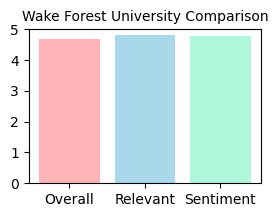
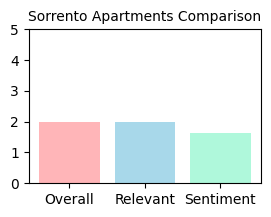
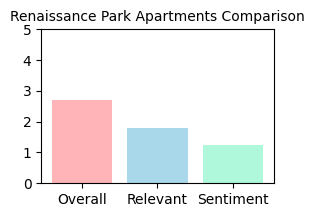
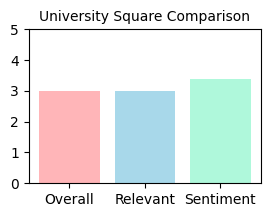
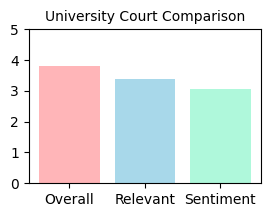
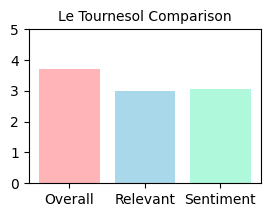
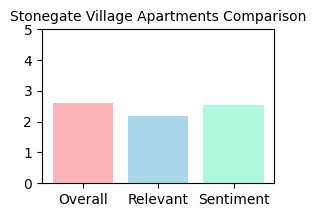
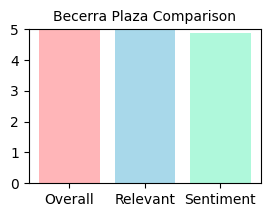
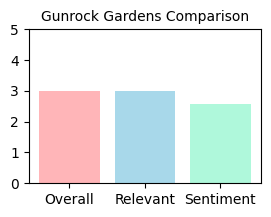
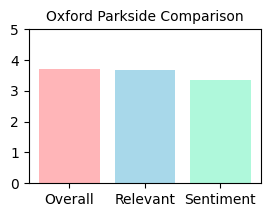
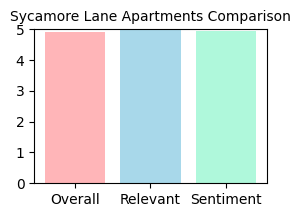
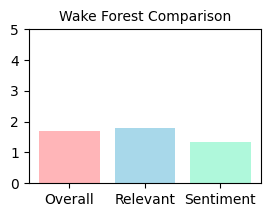
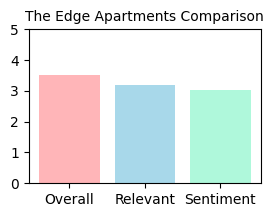
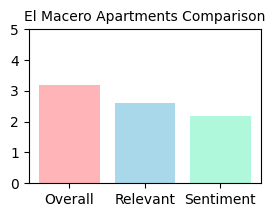
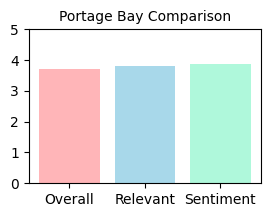
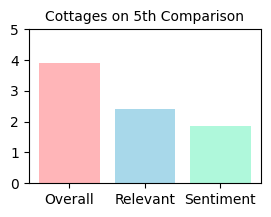
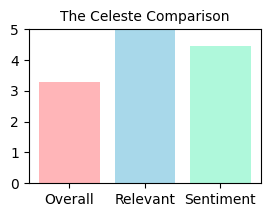
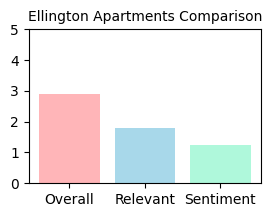
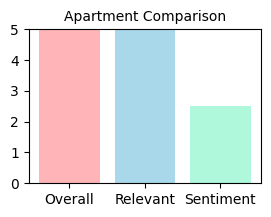
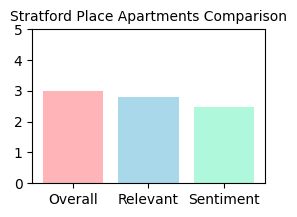
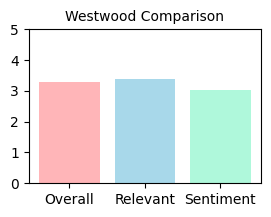
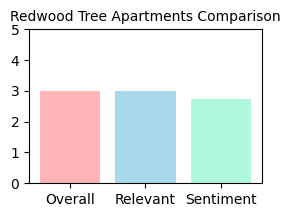
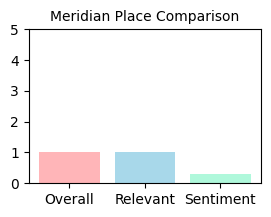
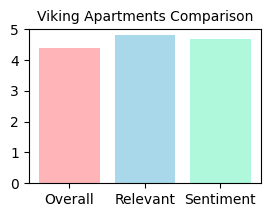
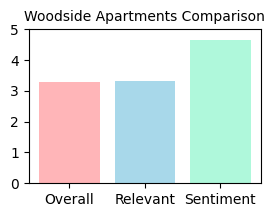
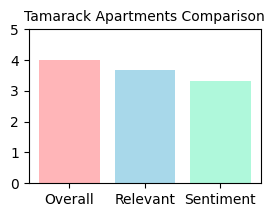
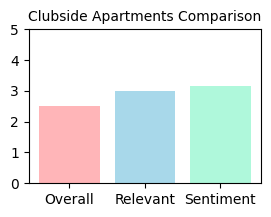
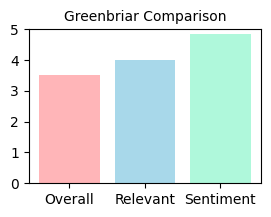
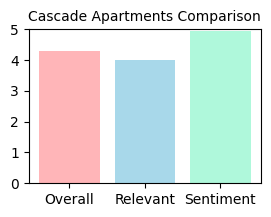
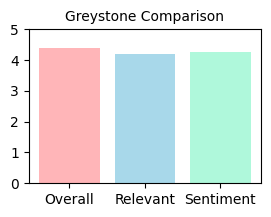
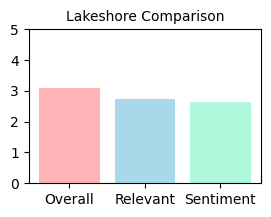
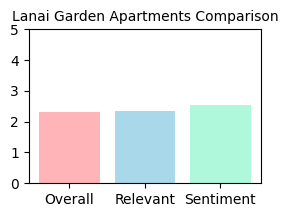
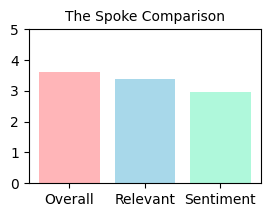
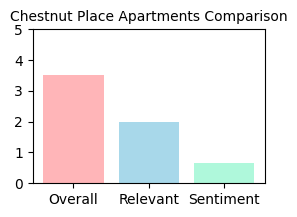
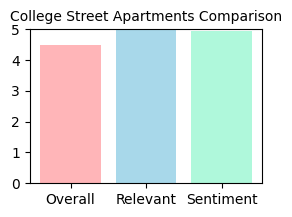
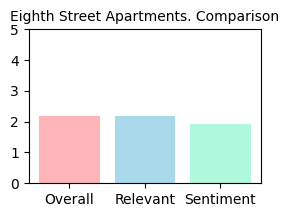
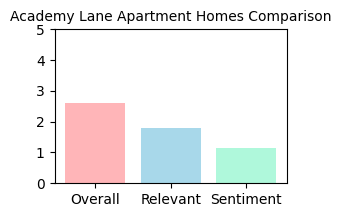
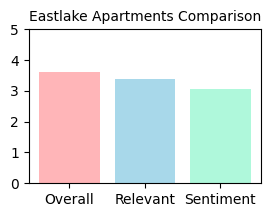
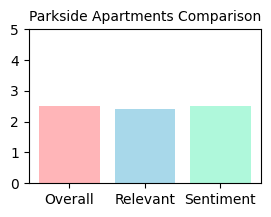
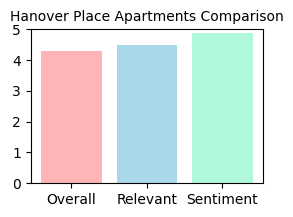
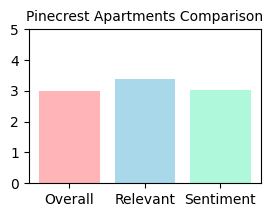
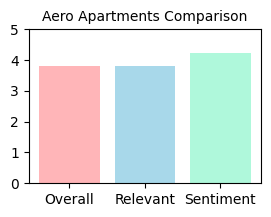
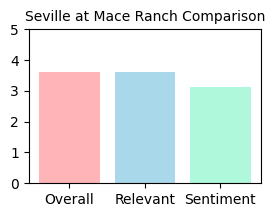
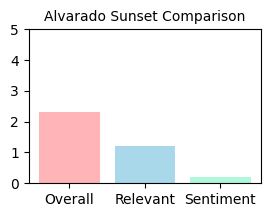
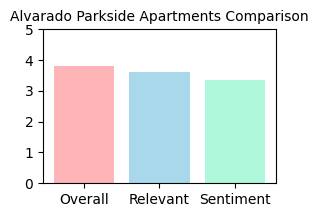
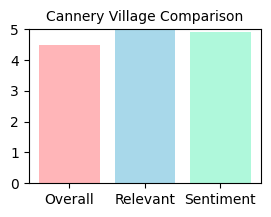
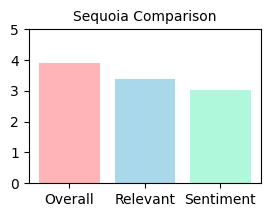
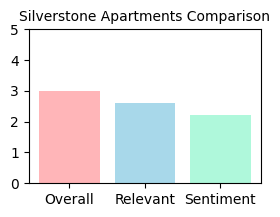

In [ ]:
plot_2d_barcharts_map(davis_sentiment_df, [38.5449, -121.7405],'davis')

In [ ]:
plot_overall(davis_sentiment_df,[38.5449, -121.7405],'davis')

In [ ]:
plot_relevant(davis_reviews_df,[38.5449, -121.7405],'davis')

In [ ]:
plot_sentiment(davis_reviews_df,[38.5449, -121.7405],'davis')

# Rental v.s Rating

In [ ]:
davis_rental_df = pd.read_excel('/content/drive/Shareddrives/STA 220 Project/davis_rental_zillow.xlsx')
wood_rental_df = pd.read_excel('/content/drive/Shareddrives/STA 220 Project/wood_rental_zillow.xlsx')
west_rental_df = pd.read_excel('/content/drive/Shareddrives/STA 220 Project/westsac_rental_zillow.xlsx')
dixon_rental_df = pd.read_excel('/content/drive/Shareddrives/STA 220 Project/dixon_rental_zillow.xlsx')

davis_sentiment_df = pd.read_excel('/content/drive/Shareddrives/STA 220 Project/davis_sentiment.xlsx')
wood_sentiment_df = pd.read_excel('/content/drive/Shareddrives/STA 220 Project/wood_sentiment.xlsx')
westsac_sentiment_df = pd.read_excel('/content/drive/Shareddrives/STA 220 Project/westsac_sentiment.xlsx')
dixon_sentiment_df = pd.read_excel('/content/drive/Shareddrives/STA 220 Project/dixon_sentiment.xlsx')

In [ ]:
def rating_df_round(df):
  df_result = df.groupby(['lat', 'lng','name', 'old_lat', 'old_lng']).mean(['rating','overall_rating','Sentiment']).reset_index()
  df_result['Sentiment'] = (5/2) * (df_result['Sentiment'] + 1)
  df_result[['rating','overall_rating','Sentiment']] = df_result[['rating','overall_rating','Sentiment']].round(2)
  return df_result

def plot_rating_price(df_rental, df_sentiment, name):
  sentiment_avg = rating_df_round(df_sentiment)
  df_rental['Unit Price'] = df_rental['Unit Price'].round(2)
  merged_df = sentiment_avg.merge(
      df_rental[['Unit Price', 'Latitude', 'Longitude']],
      left_on=['old_lat', 'old_lng'],
      right_on=[ 'Latitude', 'Longitude'],
      how='inner'
  )
  fig1 = px.scatter(
      merged_df,
      x="Unit Price",
      y="Sentiment",
      size="Sentiment",
      color="Sentiment",
      hover_name="name",
      title=f"Sentiment Score vs. Rental Price of Apartments in {name.title()}",
      labels={"Unit Price": "Rental Price ($)", "Sentiment": "Average Sentiment Score"},
      size_max=30
  )
  fig1.write_html(f"/content/drive/Shareddrives/STA 220 Project/sentiment_{name}_bubble.html")
  fig1.show()

  fig2 = px.scatter(
      merged_df,
      x="Unit Price",
      y="overall_rating",
      size="overall_rating",
      color="overall_rating",
      hover_name="name",
      title=f"Overall Rating vs. Rental Price of Apartments in {name.title()}",
      labels={"Unit Price": "Rental Price ($)", "overall_rating": "Overall Rating"},
      size_max=30
  )
  fig2.write_html(f"/content/drive/Shareddrives/STA 220 Project/overallrating_{name}_bubble.html")
  fig2.show()


In [ ]:
plot_rating_price(davis_rental_df, davis_sentiment_df,'davis')

In [ ]:
plot_rating_price(wood_rental_df, wood_sentiment_df,'woodland')

In [ ]:
plot_rating_price(west_rental_df, westsac_sentiment_df,'westsac')

In [ ]:
plot_rating_price(dixon_rental_df, dixon_sentiment_df,'dixon')